# Django REST Framework
- DRF is a powerful and flexible toolkit for building Web APIs in Django. 
- It extends Django’s capabilities beyond HTML rendering and provides tools to build RESTful JSON APIs easily.  

<img src="/Users/yannisshen/Documents/GitHub/pilot/session-08-http-and-flask/assets/rest-api.png" alt="rest" width="400"/>
<img src="/Users/yannisshen/Documents/GitHub/pilot/session-13-django-part-2-rest/django_rest.png" alt="django_rest" width="450"/>

Install
```bash
pip install djangorestframework
pip install djangorestframework-simplejwt
```

Add them to INSTALLED_APPS and add REST_FRAMEWORK in `setting.py`:
```python
INSTALLED_APPS = [
    ...
    'rest_framework',
    'rest_framework_simplejwt'
]

REST_FRAMEWORK = {
    'DEFAULT_AUTHENTICATION_CLASSES': (
        'rest_framework_simplejwt.authentication.JWTAuthentication',
    )
}
```

# Authentication
- With the **Built-in User System** talked about in Models, Django provides a complete **Built-in Authentication System** out of the box with the `django.contrib.auth` app. 
- This traditional Django's authentication is **session-based**. 
- Here, our REST API example uses **JWT (JSON Web Tokens)** for authentication, which is different from Django's traditional session-based authentication.

Call it again, Session vs JWT:

| Feature | Session-based |JWT |
|---------|--------------|-----|
|Storage| Server (database)|Client (localStorage/memory)|
|Scalability |Harder (sessions tied to servers) |Easier (stateless)|
|Security |Cookie-based (CSRF protection needed)| Token-based (no CSRF issues)|
|Use case| Traditional web apps| APIs, SPAs, mobile apps|
|Logout| Easy (delete session)| Hard (token valid until expiry)|
|Database|Query on each request|No query (validates signature)|


## Settings Configuration

```python
# settings.py
LOGIN_URL = '/login/'  # Redirect here if login required
LOGIN_REDIRECT_URL = '/'  # Redirect after login
LOGOUT_REDIRECT_URL = '/login/'  # Redirect after logout

# Password validators (already in your settings.py)
AUTH_PASSWORD_VALIDATORS = [
    {'NAME': 'django.contrib.auth.password_validation.UserAttributeSimilarityValidator'},
    {'NAME': 'django.contrib.auth.password_validation.MinimumLengthValidator'},
    {'NAME': 'django.contrib.auth.password_validation.CommonPasswordValidator'},
    {'NAME': 'django.contrib.auth.password_validation.NumericPasswordValidator'},
]
```

## Traditional Django Authentication (Session-based) 
How it works:
- User logs in → Django creates session → Stores session ID in cookie
- Browser sends cookie with every request
- Django looks up session in database
- Works well for server-rendered templates

### Authentication Views
Django provides **built-in views for authentication**. You can customize them or use as-is.

#### Setup Login View
```python
# urls.py
from django.contrib.auth import views as auth_views

urlpatterns = [
    path('login/', auth_views.LoginView.as_view(template_name='login.html'), name='login'),
    path('logout/', auth_views.LogoutView.as_view(), name='logout'),
]
```
```html
<!-- login.html -->
<form method="post">
    {% csrf_token %}
    {{ form.as_p }}
    <button type="submit">Login</button>
</form>
```

#### Registration View
```python
# views.py
from django.contrib.auth.forms import UserCreationForm
from django.shortcuts import render, redirect

def register(request):
    if request.method == 'POST':
        form = UserCreationForm(request.POST)
        if form.is_valid():
            form.save()
            return redirect('login')
    else:
        form = UserCreationForm()
    return render(request, 'register.html', {'form': form})
```

#### Login Required 
In views:   
```python
from django.contrib.auth.decorators import login_required

@login_required
def create_post(request):
    # Only logged-in users can access
    pass
```
In templates:
```html
{% if user.is_authenticated %}
    <p>Welcome, {{ user.username }}!</p>
    <a href="{% url 'logout' %}">Logout</a>
{% else %}
    <a href="{% url 'login' %}">Login</a>
{% endif %}
```

## JWT Authentication (our REST API approach)
How it works:

- User logs in → Server returns JWT tokens (access + refresh)
- Client stores tokens (usually in localStorage)
- Client sends access token in Authorization header with each request
- Server validates token (no database lookup needed!)
- Perfect for APIs and mobile apps

### Configuration 
`setting.py`:
```python
INSTALLED_APPS = [
    # ...
    'rest_framework',
    'rest_framework_simplejwt',
]

REST_FRAMEWORK = {
    'DEFAULT_AUTHENTICATION_CLASSES': (
        'rest_framework_simplejwt.authentication.JWTAuthentication',
    )
}

from datetime import timedelta

SIMPLE_JWT = {
    'ACCESS_TOKEN_LIFETIME': timedelta(minutes=15),  # Short-lived
    'REFRESH_TOKEN_LIFETIME': timedelta(days=7)      # Long-lived
}
```
JWT Endpoints (`urls.py`):
```python
from rest_framework_simplejwt.views import TokenObtainPairView, TokenRefreshView

urlpatterns = [
    path('api/login', TokenObtainPairView.as_view(), name="token_obtain_pair"),
    path('api/refresh', TokenRefreshView.as_view(), name='token_refresh')
]
```

### How to use JWT
#### Login (Get tokens)
```bash
POST /api/login
Content-Type: application/json

{
    "email": "user@example.com",
    "password": "password123"
}

# Response:
{
    "access": "eyJ0eXAiOiJKV1QiLCJhbGc...",  # Use this for requests
    "refresh": "eyJ0eXAiOiJKV1QiLCJhbGc..."  # Use this to get new access token
}
```

#### Make authenticated requests
```bash
GET /api/posts/
Authorization: Bearer <the given access token>
```

#### Refresh access token 
when it expires after 15 minutes which was set in `setting.py`
```bash
POST /api/refresh
Content-Type: application/json

{
    "refresh": <the given refresh token>
}

# Response:
{
    "access": "eyJ0eXAiOiJKV1QiLCJhbGc..."  # New access token
}
```

# Permissions System
Django has a **built-in permissions** system, and **Django REST Framework (DRF)** integrates directly with it, especially through model-level permissions

## DRF Permission Classes
These permissions live at the **API view level**. Dicide who can access this API endpoint.   
in `views.py`:
```python
from rest_framework.permissions import (
    IsAuthenticated,        # Must be logged in
    IsAdminUser,            # Must be admin (is_staff=True)
    IsAuthenticatedOrReadOnly,  # Read: anyone, Write: authenticated only
    AllowAny,               # Anyone can access
)

class PostViewSet(viewsets.GenericViewSet):
    permission_classes = [IsAuthenticated]  # All actions require login
```
Python classes that determine whether an API request is allowed, such as:

| Permission Class               | GET (read)          | POST/PUT/DELETE (write) |
|-------------------------------|----------------------|---------------------------|
| AllowAny                      | ✅ Anyone            | ✅ Anyone                 |
| IsAuthenticated               | ✅ Logged in only    | ✅ Logged in only         |
| IsAuthenticatedOrReadOnly     | ✅ Anyone            | ✅ Logged in only         |
| IsAdminUser                   | ✅ Admin only        | ✅ Admin only             |


### DRF ViewSets Comparison: ModelViewSet vs GenericViewSet
```python
    from rest_framework import viewsets, mixins
    class PostViewSet(viewsets.ModelViewSet): 
        queryset = Post.objects.all()
        serializer_class = PostSerializer
    # or
    class PostViewSet(
    mixins.ListModelMixin,          # add allowed method routes
    mixins.RetrieveModelMixin,
    mixins.CreateModelMixin,
    viewsets.GenericViewSet
    ): 
        queryset = Post.objects.all()
        serializer_class = PostSerializer
        ...
        # customize the specific operation
        @action(detail=True, methods=['POST'])    
        def publish(self, request, pk):...

```
`ModelViewSet` gives you **everything automatically**, while `GenericViewSet` lets you build up `only the operations you need` through mixins.



#### `ModelViewSet`
A **complete CRUD** viewset that combines:

- `mixins.CreateModelMixin`
- `mixins.RetrieveModelMixin`
- `mixins.UpdateModelMixin`
- `mixins.DestroyModelMixin`
- `mixins.ListModelMixin`
- `GenericViewSet`

automatically provides:

- `GET /books/` - list all
- `POST /books/` - create new
- `GET /books/{id}/` - retrieve one
- `PUT /books/{id}/` - full update
- `PATCH /books/{id}/` - partial update
- `DELETE /books/{id}/` - destroy

Use ModelViewSet when:

- You want full CRUD for a model
- Standard REST operations are sufficient
- Rapid prototyping




#### `GenericViewSet`
The base class that provides:

- Viewset behavior (action routing)
- `get_object()`, `get_queryset()` methods
- No CRUD operations by default

You explicitly mix in only what you need.

Use GenericViewSet with mixins when:

- You want read-only endpoints (List + Retrieve only)
- You need create but not delete
- You want **fine-grained control** over which operations exist
- You're building custom actions with @action decorator

| Mixin| HTTP Method| Endpoint| Action| 
| -----| -----------| ------| -------| 
| CreateModelMixin| POST| /resources/| Create | 
| newListModelMixin| GET| /resources/| List all| 
| RetrieveModelMixin| GET| /resources/{id}/| Get one| 
| UpdateModelMixin| PUT or PATCH| /resources/{id}/|Update| 
| DestroyModelMixin| DELETE| /resources/{id}/| Delete| 

### DRF Mixins Breakdown

Each mixin adds **one specific CRUD operation** to your viewset:

1. `CreateModelMixin`
   - HTTP Method: `POST`
   - What it does: **Creates a new object**
   - Generated endpoint: `POST /resources/`

   ```python
       # Provides this method:
       def create(self, request, *args, **kwargs):
           serializer = self.get_serializer(data=request.data)
           serializer.is_valid(raise_exception=True)
           self.perform_create(serializer)
           return Response(serializer.data, status=status.HTTP_201_CREATED)
   ```
2. `ListModelMixin`
   - HTTP Method: `GET` (collection)
   - What it does: **Returns a list of all objects**
   - Generated endpoint: `GET /resources/`

   ```python
       # Provides this method:
       def list(self, request, *args, **kwargs):
           queryset = self.filter_queryset(self.get_queryset())
           # Handles pagination automatically
           page = self.paginate_queryset(queryset)
           if page is not None:
               serializer = self.get_serializer(page, many=True)
               return self.get_paginated_response(serializer.data)
           
           serializer = self.get_serializer(queryset, many=True)
           return Response(serializer.data)
   ```

3. `RetrieveModelMixin`
   - HTTP Method: `GET` (single item)
   - What it does: **Returns one specific object by ID/primary key**
   - Generated endpoint: `GET /resources/{id}/`

   ```python
       # Provides this method:
       def retrieve(self, request, *args, **kwargs):
           instance = self.get_object()  # Gets object by pk from URL
           serializer = self.get_serializer(instance)
           return Response(serializer.data)
   ```

4. `UpdateModelMixin`
   - HTTP Methods: `PUT` (full update) and `PATCH` (partial update)
   - What it does: **Updates an existing object**
   - Generated endpoints:
       - `PUT /resources/{id}/`
       - `PATCH /resources/{id}/`

   ```python
       # Provides these methods:
       def update(self, request, *args, **kwargs):
           partial = kwargs.pop('partial', False)
           instance = self.get_object()
           serializer = self.get_serializer(instance, data=request.data, partial=partial)
           serializer.is_valid(raise_exception=True)
           self.perform_update(serializer)
           return Response(serializer.data)

       def partial_update(self, request, *args, **kwargs):
           kwargs['partial'] = True
           return self.update(request, *args, **kwargs)
   ```
   Example requests:
   ```json
       PUT /books/5/  # Must include ALL fields
       {
       "title": "New Title",
       "author": "Updated Author",
       "pages": 300
       }

       PATCH /books/5/  # Can include just some fields
       {
       "title": "New Title"
       }
   ```

5. `DestroyModelMixin`
   - HTTP Method: `DELETE`
   - What it does: **Deletes an object**
   - Generated endpoint: `DELETE /resources/{id}/`

   ```python
       # Provides this method:
       def destroy(self, request, *args, **kwargs):
           instance = self.get_object()
           self.perform_destroy(instance)
           return Response(status=status.HTTP_204_NO_CONTENT)
   ```
   Example request:
   ```json
       DELETE /books/5/
   ```
   Returns: 204 No Content (empty response)

#### Common Combinations

1. Read-only API
   ```python
    class BookViewSet(mixins.ListModelMixin,
                      mixins.RetrieveModelMixin,
                      viewsets.GenericViewSet):
    # GET /books/  ✓
    # GET /books/{id}/  ✓
    # No create, update, or delete
   ```
2. Create + Read only (no updates/deletes)
   ```python
   class BookViewSet(mixins.CreateModelMixin,
                    mixins.ListModelMixin,
                    mixins.RetrieveModelMixin,
                    viewsets.GenericViewSet):
    # POST /books/  ✓
    # GET /books/  ✓
    # GET /books/{id}/  ✓
   ```
3. Everything except delete
   ```python
   class BookViewSet(mixins.CreateModelMixin,
                    mixins.RetrieveModelMixin,
                    mixins.UpdateModelMixin,
                    mixins.ListModelMixin,
                    viewsets.GenericViewSet):
    # All operations except DELETE
   ```

## Django Model Permissions 
### built-in Django model permissions
These permissions live at the **database/model level**. Decide who can perform CRUD on the model. For each model, Django **automatically creates 4 permissions**:

- add_modelname
- change_modelname
- delete_modelname
- view_modelname (Django 2.1+)

Our example:   
- `add_post`: Can add post
- `change_post`: Can change post
- `delete_post`: Can delete post
- `view_post`: Can view post

Stored in the **auth_permission table**.   
Enforced by Django’s admin, ORM, and your own views if you check them.  
Checking if a user can perform an action on a model, e.g.:
```python
user.has_perm("blog.change_post")
```

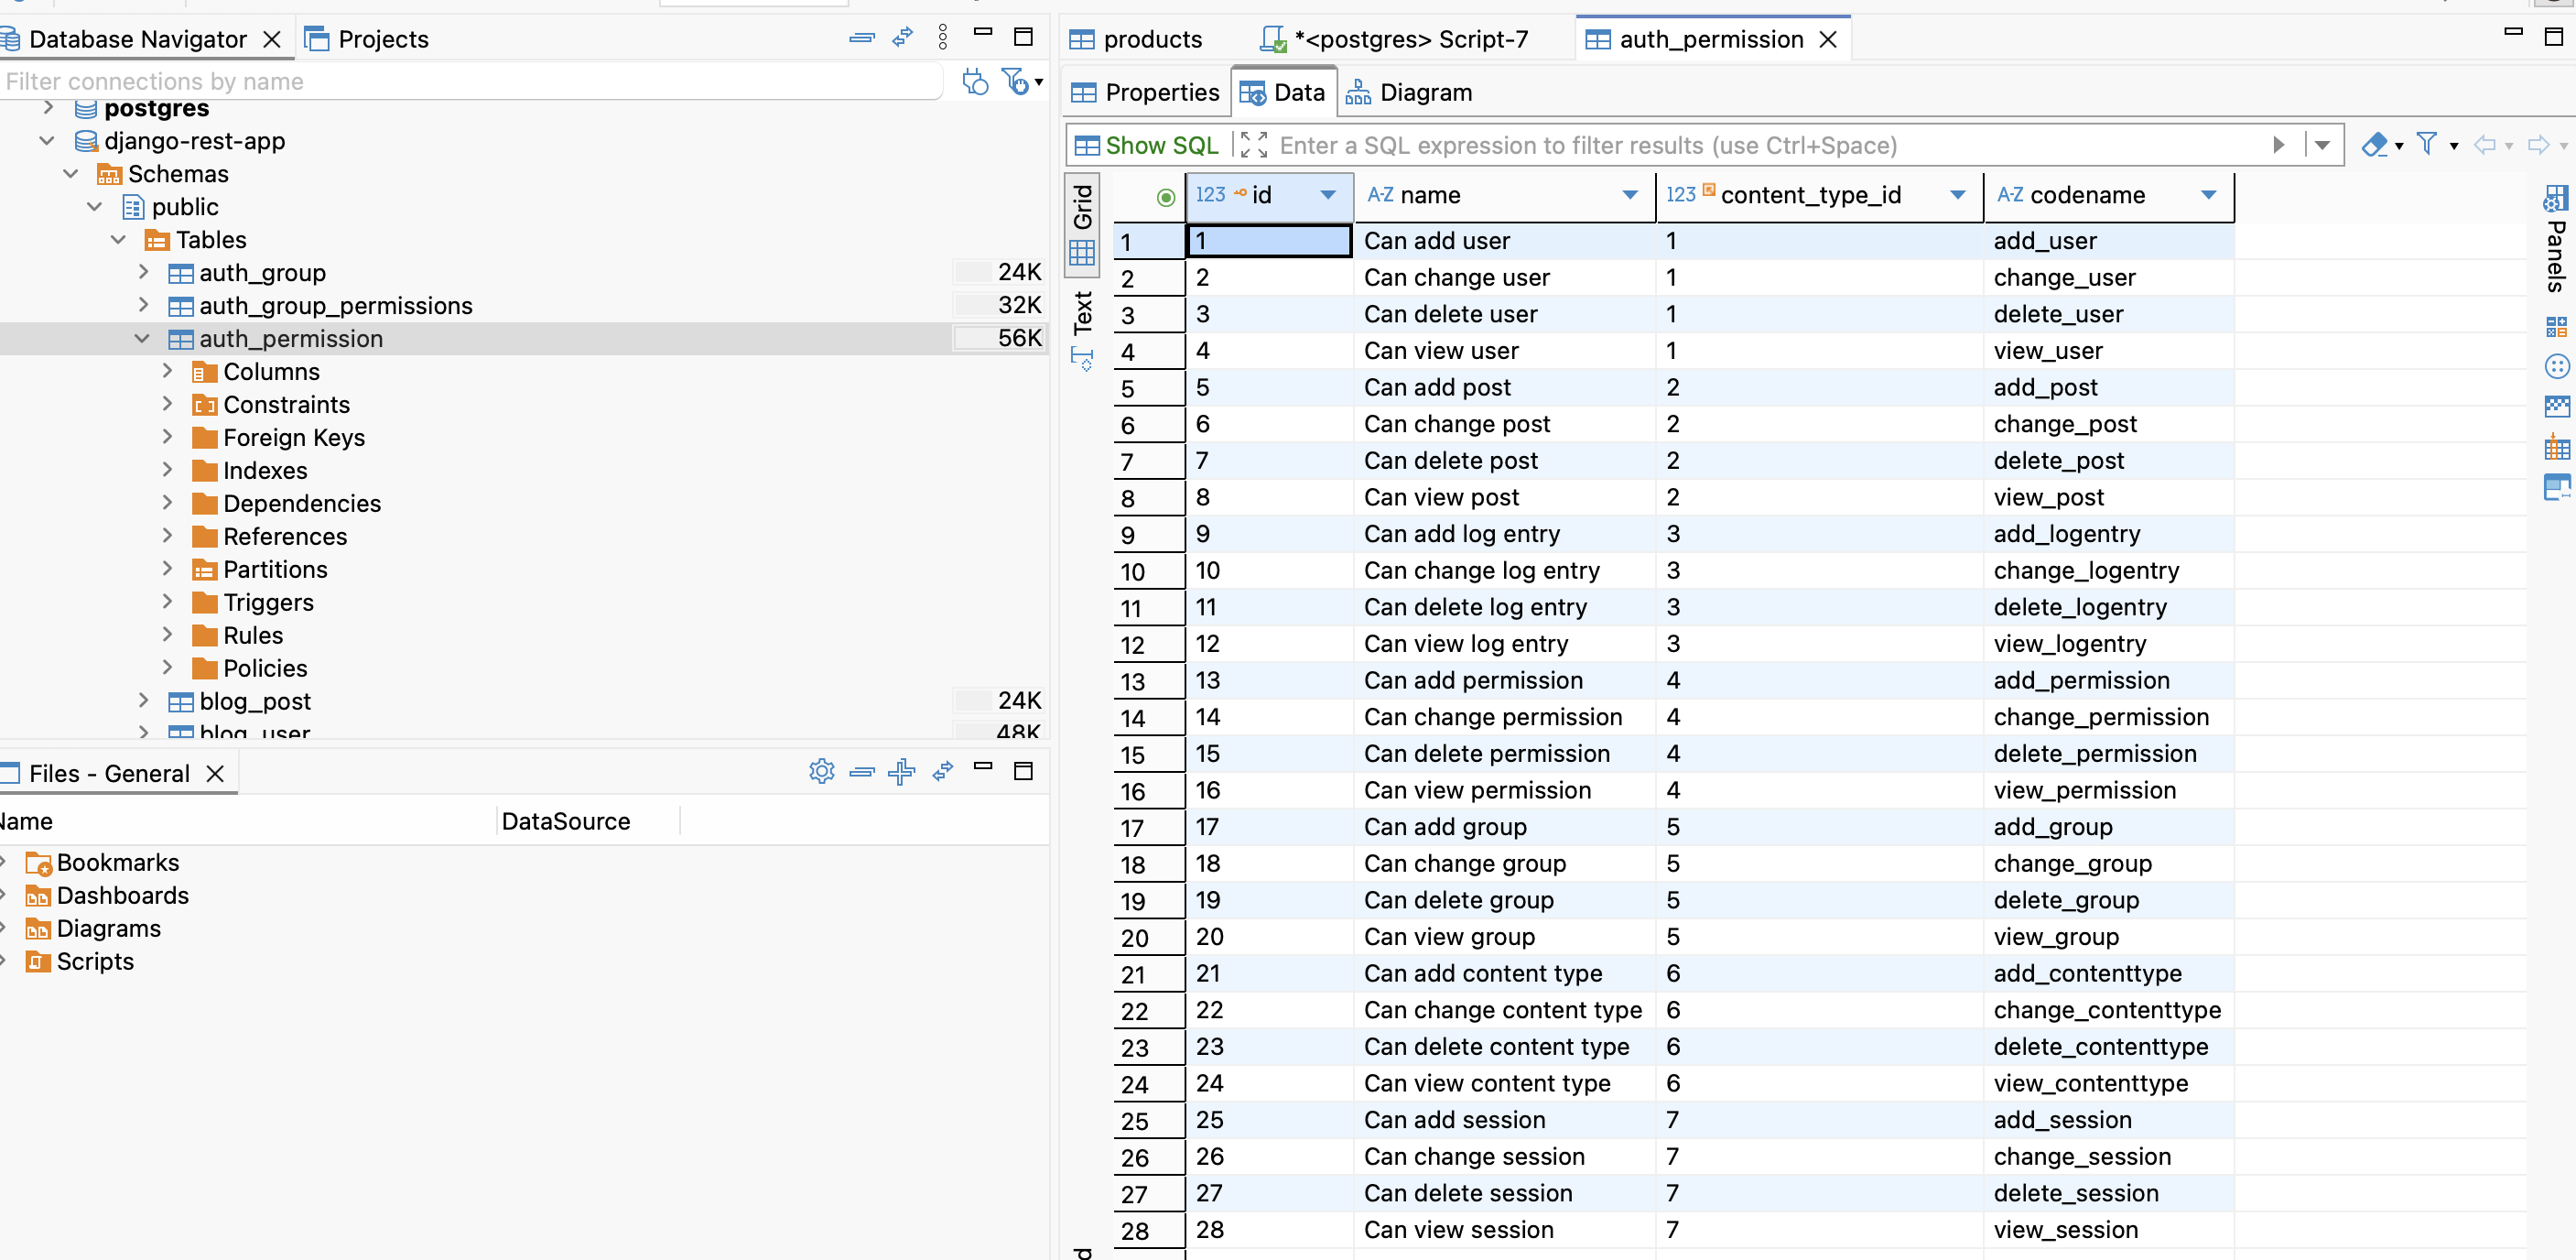  

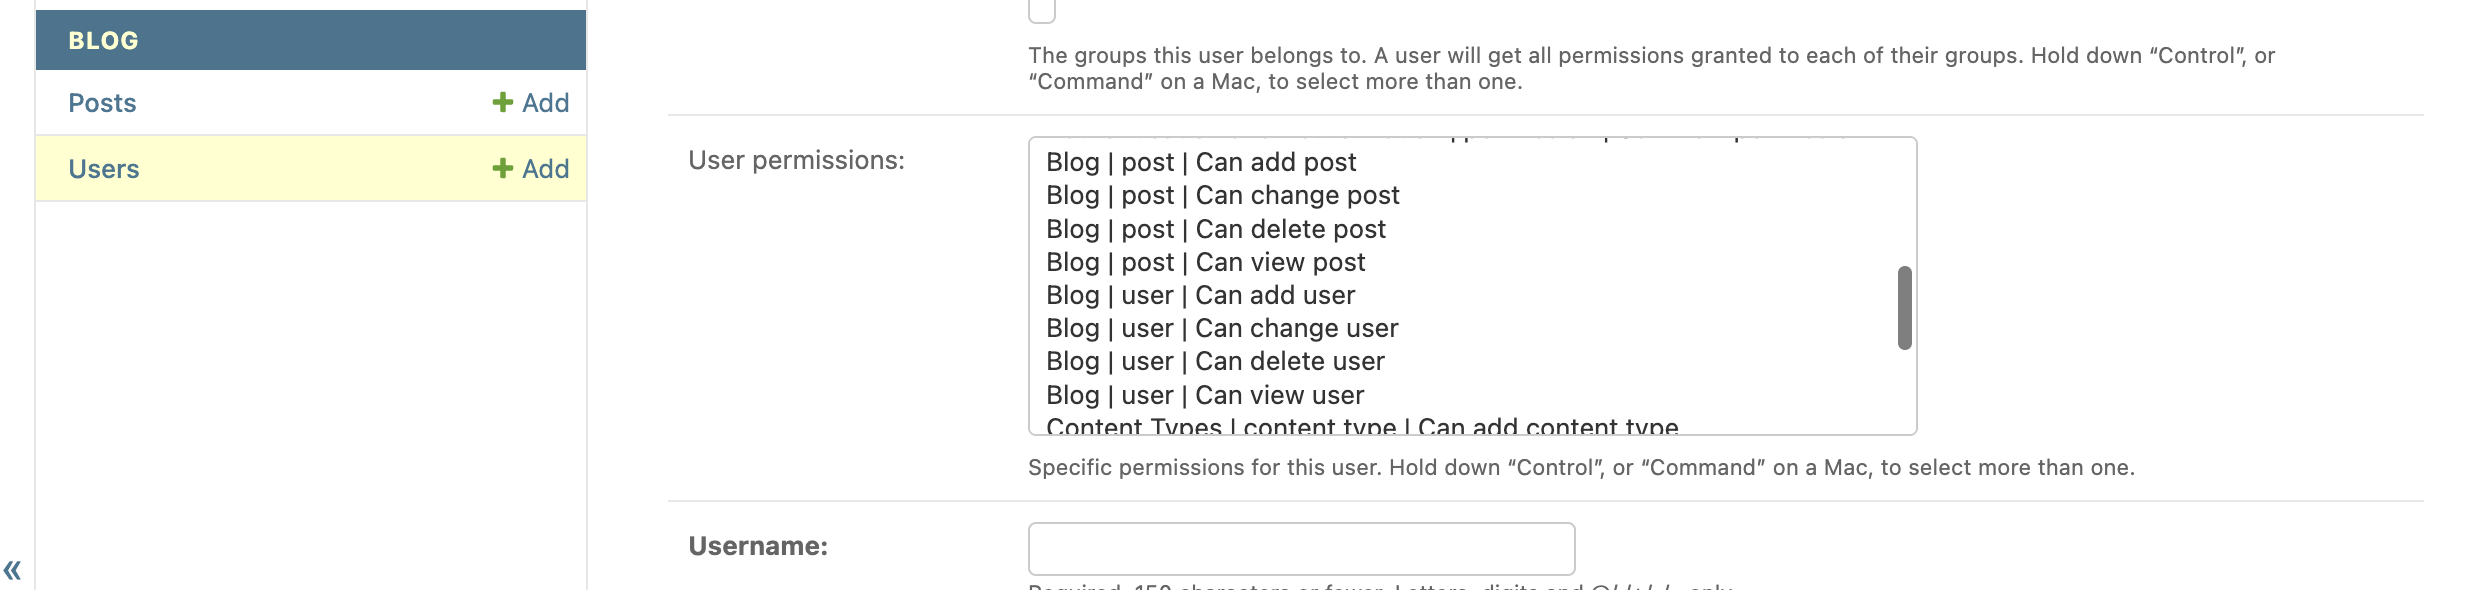

### Custom model Permissions
```python
class Post(models.Model):
    # ... fields ...
    
    class Meta:
        permissions = [
            ("publish_post", "Can publish post"),
            ("feature_post", "Can feature post"),
        ]
# Usage:
if request.user.has_perm('blog.publish_post'):
    post.published = True
```

## Checking Permissions 
### in Views

```python
    from django.contrib.auth.decorators import permission_required

    @permission_required('blog.add_post')
    def create_post(request):
        # Only users with add_post permission can access
        pass

    # Check multiple permissions
    @permission_required(['blog.add_post', 'blog.change_post'])
    def edit_post(request, post_id):
        pass
```

### in Templates

```html
    {% if perms.blog.add_post %}
        <a href="{% url 'blog:create_post' %}">Create Post</a>
    {% endif %}

    {% if perms.blog.change_post %}
        <a href="{% url 'blog:edit_post' post.id %}">Edit</a>
    {% endif %}
```


## Permission Methods in ViewSets

Can dynamically set permissions:
```python
    class PostViewSet(viewsets.GenericViewSet):
        permission_classes = [IsAuthenticated]  # Default for all actions
        
        def get_permissions(self):
            """
            Override to set different permissions per action
            """
            if self.action == 'list':
                # Anyone can list posts
                return [AllowAny()]
            elif self.action == 'create':
                # Only users with permission can create
                return [IsAuthenticated(), HasCreatePostPermission()]
            elif self.action in ['update', 'partial_update', 'destroy']:
                # Only author can modify
                return [IsAuthenticated(), IsAuthorOrReadOnly()]
            
            return super().get_permissions()
```

## User Groups
Groups allow you to categorize users and assign permissions in bulk

```python
    from django.contrib.auth.models import Group, Permission

    # Create group
    editors = Group.objects.create(name='Editors')

    # Add permissions to group
    permission = Permission.objects.get(codename='change_post')
    editors.permissions.add(permission)

    # Add user to group
    user.groups.add(editors)

    # Check if user is in group
    if user.groups.filter(name='Editors').exists():
        # User is an editor
        pass
```



In permission classes:
```python
    class IsEditor(permissions.BasePermission):
        def has_permission(self, request, view):
            return request.user.groups.filter(name='Editors').exists()
```

Apply it in ViewsSet:  
```python
    class PostViewSet(...):
        permission_classes = [IsEditor]
```

## Row-Level Permissions
Restrict access to specific objects (not built-in, requires manual implementation):
```python
def edit_post(request, post_id):
    post = get_object_or_404(Post, id=post_id)
    
    # Only author can edit
    if post.author != request.user:
        return HttpResponseForbidden("You can't edit this post")
    
    # ... edit logic ...
```


## Apply Custom Permissions in DRF Summary

### 1. In ViewSets/APIViews
Class-level (applies to all actions)

```python
# assume IsEditor is defined in permissions.py
from rest_framework import viewsets
from .permissions import IsEditor

class ArticleViewSet(viewsets.ModelViewSet):
    queryset = Article.objects.all()
    serializer_class = ArticleSerializer
    permission_classes = [IsEditor]  # All actions require Editor group
    # Multiple permissions (ALL must pass):
    permission_classes = [IsAuthenticated, IsEditor]  # User must be authenticated AND editor
```

### 2. Per-Action Permissions in ViewSets
**Different permissions for different actions**:  
```python
from rest_framework.decorators import action
from rest_framework.permissions import IsAuthenticated, AllowAny

class ArticleViewSet(viewsets.ModelViewSet):
    queryset = Article.objects.all()
    serializer_class = ArticleSerializer
    
    def get_permissions(self):
        """
        Customize permissions per action
        """
        if self.action == 'list':
            # Anyone can list articles
            permission_classes = [AllowAny]
        elif self.action == 'retrieve':
            # Anyone can view a single article
            permission_classes = [AllowAny]
        elif self.action in ['create', 'update', 'partial_update']:
            # Only editors can create/update
            permission_classes = [IsEditor]
        elif self.action == 'destroy':
            # Only authenticated admins can delete
            permission_classes = [IsAuthenticated, IsAdminUser]
        else:
            # Default for custom actions
            permission_classes = [IsAuthenticated]
        
        return [permission() for permission in permission_classes]
```

### 3. On Custom Actions
Using @action decorator with permission_classes

```python
from rest_framework.decorators import action
from rest_framework.response import Response

class ArticleViewSet(viewsets.ModelViewSet):
    queryset = Article.objects.all()
    serializer_class = ArticleSerializer
    permission_classes = [IsAuthenticated]  # Default for all actions
    
    @action(detail=True, methods=['post'], permission_classes=[IsEditor])
    def publish(self, request, pk=None):
        """Only editors can publish articles"""
        article = self.get_object()
        article.published = True
        article.save()
        return Response({'status': 'article published'})
    
    @action(detail=False, methods=['get'], permission_classes=[AllowAny])
    def recent(self, request):
        """Anyone can view recent articles"""
        recent_articles = Article.objects.filter(published=True)[:10]
        serializer = self.get_serializer(recent_articles, many=True)
        return Response(serializer.data)
```

### 4. Function-Based Views
Using decorators

```python
from rest_framework.decorators import api_view, permission_classes
from rest_framework.response import Response

@api_view(['GET', 'POST'])
@permission_classes([IsEditor])
def article_list(request):
    if request.method == 'GET':
        articles = Article.objects.all()
        serializer = ArticleSerializer(articles, many=True)
        return Response(serializer.data)
    
    elif request.method == 'POST':
        serializer = ArticleSerializer(data=request.data)
        if serializer.is_valid():
            serializer.save()
            return Response(serializer.data, status=201)
        return Response(serializer.errors, status=400)
```

### 5. Class-Based Views (APIView)

```python
from rest_framework.views import APIView
from rest_framework.response import Response

class ArticleList(APIView):
    permission_classes = [IsEditor]
    
    def get(self, request):
        articles = Article.objects.all()
        serializer = ArticleSerializer(articles, many=True)
        return Response(serializer.data)
    
    def post(self, request):
        serializer = ArticleSerializer(data=request.data)
        if serializer.is_valid():
            serializer.save()
            return Response(serializer.data, status=201)
        return Response(serializer.errors, status=400)
```

### 6. Global Default Permissions

In `settings.py`:
```python
REST_FRAMEWORK = {
    'DEFAULT_PERMISSION_CLASSES': [
        'rest_framework.permissions.IsAuthenticated',
        'myapp.permissions.IsEditor',
    ]
}
```
Then override in specific views:
```python
class PublicArticleViewSet(viewsets.ModelViewSet):
    queryset = Article.objects.filter(published=True)
    serializer_class = ArticleSerializer
    permission_classes = [AllowAny]  # Override global default
```

### 7. Object-Level Permissions
For checking permissions on specific objects (like "can this user edit THIS article")

```python

class IsAuthorOrReadOnly(permissions.BasePermission):
    """
    Object-level permission: only authors can edit their own articles
    """
    def has_object_permission(self, request, view, obj):
        # Read permissions for anyone
        if request.method in permissions.SAFE_METHODS:
            return True
        
        # Write permissions only for the author
        return obj.author == request.user


class ArticleViewSet(viewsets.ModelViewSet):
    queryset = Article.objects.all()
    serializer_class = ArticleSerializer
    permission_classes = [IsAuthenticated, IsAuthorOrReadOnly]
    # has_permission checks first (class-level)
    # has_object_permission checks for retrieve/update/delete (object-level)
```

### 8. Combining Multiple Custom Permissions

```python
class IsEditorOrAuthor(permissions.BasePermission):
    """
    User must be either an Editor OR the author of the article
    """
    def has_object_permission(self, request, view, obj):
        # Check if user is an editor
        is_editor = request.user.groups.filter(name='Editors').exists()
        
        # Check if user is the author
        is_author = obj.author == request.user
        
        return is_editor or is_author


class ArticleViewSet(viewsets.ModelViewSet):
    queryset = Article.objects.all()
    serializer_class = ArticleSerializer
    permission_classes = [IsAuthenticated, IsEditorOrAuthor]
```

## Permission Check Flow

1. `has_permission()` - Checks before any action (class-level)

    - Returns False → 403 Forbidden immediately
    - Returns True → Continue to step 2


2. has_object_permission() - Checks for specific object (only for retrieve/update/destroy)

    - Called after get_object() is executed
    - Returns False → 403 Forbidden
    - Returns True → Action proceeds

# Django Forms
Note: The REST API doesn't use traditional Django Forms.  
Instead, it uses **Django REST Framework Serializers** which serve a similar purpose for APIs.

| Traditional Django               | REST API                         |
|----------------------------------|----------------------------------|
| Serves HTML templates            | Serves JSON                      |
| Static files for frontend        | No frontend in Django            |
| Uses `{% static %}` in templates | API returns media URLs           |
| All-in-one (backend + frontend)  | Separate frontend & backend      |


## Traditional Django Forms (for HTML forms)
Django forms handle HTML form rendering, validation, and data processing.  

### Form Types
- **Form**: For non-model data
- **ModelForm**: Automatically generated from models

#### Basic Form
```python
    # forms.py
    from django import forms

    class ContactForm(forms.Form):
        name = forms.CharField(max_length=100)
        email = forms.EmailField()
        message = forms.CharField(widget=forms.Textarea)
        
        # Custom validation
        def clean_email(self):
            email = self.cleaned_data['email']
            if not email.endswith('@example.com'):
                raise forms.ValidationError("Email must be from example.com")
            return email
```

#### ModelForm
Automatically creates a form from a model:  

```python
# forms.py
from django import forms
from blog.models import Post

class PostForm(forms.ModelForm):
    class Meta:
        model = Post
        fields = ['title', 'content', 'published']
        # Or exclude fields:
        # exclude = ['author', 'created_at']
        
        # Custom widgets
        widgets = {
            'content': forms.Textarea(attrs={'rows': 10}),
        }
        
        # Custom labels
        labels = {
            'published': 'Publish immediately?',
        }
        
        # Help text
        help_texts = {
            'title': 'Enter a catchy title',
        }
```



### Using Forms in Views
```python
    # views.py
    from django.shortcuts import render, redirect
    from blog.forms import PostForm

    def create_post(request):
        if request.method == 'POST':
            form = PostForm(request.POST)
            if form.is_valid():
                post = form.save(commit=False)
                post.author = request.user  # Set the author
                post.save()
                return redirect('blog:post_detail', post.id)
        else:
            form = PostForm()
        
        return render(request, 'create_post.html', {'form': form})

    def edit_post(request, post_id):
        post = get_object_or_404(Post, id=post_id)
        
        if request.method == 'POST':
            form = PostForm(request.POST, instance=post)
            if form.is_valid():
                form.save()
                return redirect('blog:post_detail', post.id)
        else:
            form = PostForm(instance=post)
        
        return render(request, 'edit_post.html', {'form': form, 'post': post})
```

### Rendering Forms in Templates
```html
<!-- Method 1: Automatic rendering -->
<form method="post">
    {% csrf_token %}
    {{ form.as_p }}
    <button type="submit">Submit</button>
</form>

<!-- Method 2: Manual field rendering -->
<form method="post">
    {% csrf_token %}
    
    <div>
        {{ form.title.label_tag }}
        {{ form.title }}
        {% if form.title.errors %}
            <span class="error">{{ form.title.errors }}</span>
        {% endif %}
    </div>
    
    <button type="submit">Submit</button>
</form>
```

## REST Framework Serializers
Serializers are Django REST Framework's version of forms. They convert complex data types (model instances) to JSON and vice versa.

check `serializers.py`


### How Serializers Work
#### Serialization (Model → JSON):

In [1]:
# to run django shell in jupyter lab: 
import sys
import os
import django

# Add project root to path
project_root = '/Users/yannisshen/Documents/GitHub/pilot/session-13-django-part-2-rest/blogsite'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Set Django settings
os.environ['DJANGO_SETTINGS_MODULE'] = 'blogsite.settings'

# IMPORTANT: Allow Django to run in async context (Jupyter)
os.environ['DJANGO_ALLOW_ASYNC_UNSAFE'] = 'true'

# Import settings and modify logging config
from django.conf import settings
settings.LOGGING_CONFIG = None

# Setup Django
django.setup()

print("✓ Django setup complete!")

✓ Django setup complete!


In [2]:
from blog.models import Post
from blog.serializers import PostSerializer

post = Post.objects.get(id=1)
serializer = PostSerializer(post)
print(serializer.data)
# Output: {'id': 1, 'title': 'My Post', 'content': '...', ...}

# For multiple objects:
posts = Post.objects.all()
serializer = PostSerializer(posts, many=True)
print(serializer.data)

{'id': 1, 'author_email': 'admin@admin.com', 'title': 'My Post', 'content': 'This is the first post.', 'created_at': '2025-12-25T23:07:35.697947Z', 'updated_at': '2025-12-25T23:07:35.697976Z', 'published': False, 'author': 1}
[{'id': 1, 'author_email': 'admin@admin.com', 'title': 'My Post', 'content': 'This is the first post.', 'created_at': '2025-12-25T23:07:35.697947Z', 'updated_at': '2025-12-25T23:07:35.697976Z', 'published': False, 'author': 1}]


#### Deserialization (JSON → Model):

In [3]:
# Incoming JSON data
data = {
    'title': 'New Post',
    'content': 'Post content...',
    'author': 1,
    'published': False
}

serializer = PostSerializer(data=data)
if serializer.is_valid():
    serializer.save()  # Creates Post object
    print(serializer.data)
else:
    print(serializer.errors)

{'id': 2, 'author_email': 'admin@admin.com', 'title': 'New Post', 'content': 'Post content...', 'created_at': '2025-12-25T23:46:51.956144Z', 'updated_at': '2025-12-25T23:46:51.956164Z', 'published': False, 'author': 1}


### Different Serializers for Different Actions
`views.py`:
```python
class PostViewSet(viewsets.GenericViewSet):
    ...
    def get_serializer_class(self):
        """
        Return different serializers based on the action
        """
        if self.action == 'list':
            return PostListSerializer      # Lighter, for list view
        elif self.action == 'retrieve':
            return PostDetailsSerializer   # More details, nested author
        else:
            return PostSerializer          # Default, for create/update
```

Why different serializers?

- List view: Return minimal data (faster, less bandwidth)
- Detail view: Return full data with nested relationships
- Create/Update: Accept all writable fields

### Validation in Serializers
```python
class PostSerializer(serializers.ModelSerializer):
    class Meta:
        model = Post
        fields = '__all__'
    
    # Field-level validation
    def validate_title(self, value):
        if 'spam' in value.lower():
            raise serializers.ValidationError("Title contains spam")
        return value
    
    # Object-level validation
    def validate(self, data):
        if data.get('title') == data.get('content'):
            raise serializers.ValidationError(
                "Title and content cannot be the same"
            )
        return data
```

# Static Files Serving
Note: Since this blog project is a REST API (returns JSON, not HTML), static files are typically not used in the Django backend. However, you may serve static files for:

- Admin interface CSS/JS
- API documentation pages
- If you add a frontend later

Static files include CSS, JavaScript, images, and other assets that don't change.

## Configuration and file structure
In `settings.py`:
```python
# URL prefix for static files
STATIC_URL = 'static/'

# Directories where Django looks for static files (development)
STATICFILES_DIRS = [
    BASE_DIR / "static",  # Project-level static files
]

# Directory where collectstatic gathers all static files (production)
STATIC_ROOT = BASE_DIR / "staticfiles"
```
Directory Structure: 
```text
blogsite/
├── static/              # Project-level static files
│   ├── css/
│   │   └── style.css
│   ├── js/
│   │   └── script.js
│   └── images/
│       └── logo.png
└── blog/
    └── static/          # App-level static files
        └── blog/        # Namespaced by app name
            ├── css/
            │   └── blog.css
            └── js/
                └── blog.js
```

## Using Static Files in Templates
```html
{% load static %}

<!DOCTYPE html>
<html>
<head>
    <link rel="stylesheet" href="{% static 'css/style.css' %}">
    <link rel="stylesheet" href="{% static 'blog/css/blog.css' %}">
</head>
<body>
    <img src="{% static 'images/logo.png' %}" alt="Logo">
    
    <script src="{% static 'js/script.js' %}"></script>
    <script src="{% static 'blog/js/blog.js' %}"></script>
</body>
</html>
```

## Development vs Production
### Development (DEBUG = True):

- Django serves static files automatically
- Uses `django.contrib.staticfiles` app
- Slow but convenient

### Production (DEBUG = False):

- Configure web server (nginx, Apache, Cloudflare) to serve static files directly
- Never let Django serve static files in production (very slow!)
- Run `python manage.py collectstatic` to gather all static files into `STATIC_ROOT`.    
    
This command copies all static files from:   
- Each app's static/ directory
- Directories in STATICFILES_DIRS      

To a single directory defined by STATIC_ROOT

# Media Files
If there are Media files, which are user-uploaded files (different from static files), configure them in `settings.py` and `urls.py`:

```python
# settings.py
MEDIA_URL = '/media/'
MEDIA_ROOT = BASE_DIR / 'media'

# urls.py (development only)
from django.conf import settings
from django.conf.urls.static import static

urlpatterns = [
    # ... your patterns ...
]

if settings.DEBUG:
    urlpatterns += static(settings.MEDIA_URL, document_root=settings.MEDIA_ROOT)
```

In models:

```python
class Post(models.Model):
    image = models.ImageField(upload_to='post_images/')  # Saved to media/post_images/
    document = models.FileField(upload_to='documents/')
```

Then API endpoint would return:
```json
{
    "id": 1,
    "title": "My Post",
    "image": "http://localhost:8000/media/post_images/photo.jpg"
}
```